# Clustering in Human Resources Management

As described in my earlier notebook, we will be building a Clustering model to group employees with similar characteristics to segment the workforce into "buckets" for broad talent-development strategies.

In [1]:
#basic libraries
import pandas as pd
import numpy as np
import math
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint #pretty printing

#define graph settings
sns.set(style = "whitegrid")

#ignore warnings
import warnings
warnings.filterwarnings("ignore")

#machine learning packages
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans
from kmodes.kmodes import KModes
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
from sklearn.metrics import silhouette_score

%matplotlib inline

## <mark> Initilize the dataset

We will utilize the cleaned dataset with the new features we created from our earlier notebook: "HRProject_MachineLearning_DataCleaning&EDA". The code below imports the data:

In [2]:
df = pd.read_csv("dummy_HR_data_ML.csv")
pd.set_option('display.max_columns', None)
df.head()

,emp_id,BusinessUnit_Primary,Function,Country,Pay_Grade,EmpDuration_Company,EmpDuration_Position,Gender,Age_Decade,Race,Graduate,AttritionRisk,ForeignCountry,Position_>3Y,Position_>5Y,Seniority,JobTitleAgg,PromoEligibility,TargetedRoleIdentified,PerformanceRank_Current,PerformanceRank_LastYear,PotentialRank_Current,PotentialRank_LastYear,ChangeInPerformanceRank,ChangeInPotentialRank
0,1,BU_P1,Others,GL,1,15.0,12.5,Female,5,Hispano,No,1,0,1,1,1,Admin Assistant,0,0,2,2,2,2,0,0
1,2,BU_P1,Others,GL,1,15.0,12.5,Female,4,British,No,1,0,1,1,1,Admin Assistant,0,0,2,2,2,2,0,0
2,3,BU_P1,Sales & Marketing,GL,5,12.5,12.5,Male,6,British,No,1,1,1,1,3,Manager,0,0,2,2,2,2,0,0
3,4,BU_P1,Sales & Marketing,GL,3,2.0,2.0,Female,4,Chinese,No,1,1,0,0,2,Adviser,0,0,3,3,3,3,0,0
4,5,BU_P1,Sales & Marketing,CA,2,15.0,2.0,Female,5,Scottish,No,1,0,0,0,1,Analyst,0,0,3,3,3,3,0,0


From the above, as our objective is to group employees for broad talent-development strategies across the firm, we will select features that describe the characteristics of an employee. Therefore features such as: 'BusinessUnit_Primary', 'Function', 'Country', 'JobTitleAgg', 'ForeignCountry' will be excluded as we are interested in more general groups rather than business-related or country-related groups.

We will also exclude: 'Gender' and 'Race' to avoid discriminatory practices. Lastly, we will also exclude 'Graduate' as we observed that the distribution is highly skewed towards non-Graduates and is unlikely to be useful to cluster employees given the skewness.

In [3]:
#defining the excluded columns
exclude_col = ['BusinessUnit_Primary', 'Function', 'Country', 'JobTitleAgg', 'ForeignCountry',
               'Gender', 'Race', 'Graduate',
               'emp_id', #drop the identifier
               'TargetedRoleIdentified', #drop as highly correlated with 'PromoEligibility'
               'Position_>5Y', #we drop either 'Position_>3Y' or 'Position_>5Y'
               'PerformanceRank_LastYear', 'PotentialRank_LastYear', #we drop last year metrics
               'ChangeInPerformanceRank', 'ChangeInPotentialRank', #we drop change in metrics
               #dropped additional columns as it was observed not to have a good separation
               'Seniority', 'Pay_Grade']

#defining the list of columns for clustering exercise
target_col = [col for col in df.columns.tolist() if col not in exclude_col]
target_col

['EmpDuration_Company',
 'EmpDuration_Position',
 'Age_Decade',
 'AttritionRisk',
 'Position_>3Y',
 'PromoEligibility',
 'PerformanceRank_Current',
 'PotentialRank_Current']

## <mark> Clustering with K-Means
    
We will first attempt to cluster employees with the most widely-used clustering algorithm: K-Means. It is well-known for its efficiency in clustering large data sets since it relies only on basic linear algebra operations, making it massively scalable.

**K-Means clustering:**
K-means clustering separates a dataset into K clusters of equal variance. The number of clusters, K, is user defined. The basic algorithm has the following steps:
1. A set of K centroids are randomly chosen. 
2. Clusters are formed by minimizing variance within each cluster. This metric is also know as the **within cluster sum of squares**. This step partitions the data into clusters with minimum squared distance to the centroid of the cluster. 
3. The centroids are moved to mean of each cluster. The means of each cluster is computed and the centroid is moved to the mean. 
4. Steps 2 and 3 are repeated until a stopping criteria is met. Typically, the algorithm terminates when the within cluster variance decreases only minimally. 
5. The above steps are repeated starting with a random start of step 1. The best set of clusters by within cluster variance and between cluster separation are retained.
    
Before we apply K-Means to our features, as it is a distance-based algorithm, we have to scale the values to prevent features that have a larger range from dominating features with a smaller range.

In [4]:
#scale the features
data = df[target_col]
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

To overcome the issue of initialization sensitivity with K-means, we will use K-Means++, a smart centroid initialization technique:
- K-Means++ will pick the first centroid point (C_1) randomly,
- Compute distance of all points in the dataset from the selected centroid. The distance of x_i point from the farthest centroid can be computed by d_i = max(j:1->m)||x_i - C_j||^2
- Make the point x_i as the new centroid that is having the maximum probability proportional to d_i
- Repeat the above 2 steps until you kind k-centroids

In the code below, we will loop-through 2 to 10 clusters to initialize k-means. We will also create an evaluation table that will help us determine the optimal number of clusters dependent on a few evaluation metrics (more on this later).

In [5]:
#choosing optimal K
#calculate n-1 samples for variance calculation
n_1 = (float(data_scaled.shape[0]) * float(data_scaled.shape[1])) - 1.0

#calculate the Total Sum of Squares
TSS = n_1 * np.var(data_scaled)
WCSS = []
BCSS = []
SC = []
for cluster in range (2, 10):
    try: 
        kmeans = KMeans(n_clusters = cluster, init = "k-means++", random_state = 100)
        kmeans.fit_predict(data_scaled)
        WCSS.append(kmeans.inertia_)
        BCSS.append(TSS - kmeans.inertia_)
        cluster_labels = kmeans.labels_
        silhouette_avg = silhouette_score(data_scaled, cluster_labels)
        SC.append(silhouette_avg)
        print("Cluster initiation: {}".format(cluster))
    except:
        break

#converting the results into a dataframe and plotting them
eval_kmeans = pd.DataFrame({'Cluster': range(2, 10), 'WCSS': WCSS, 'BCSS': BCSS, 'SC': SC})

eval_kmeans

Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5
Cluster initiation: 6
Cluster initiation: 7
Cluster initiation: 8
Cluster initiation: 9


,Cluster,WCSS,BCSS,SC
0,2,5697.079358,1845.920642,0.349264
1,3,4220.665674,3322.334326,0.366072
2,4,3687.851939,3855.148061,0.322357
3,5,3315.290735,4227.709265,0.274014
4,6,3061.270846,4481.729154,0.286224
5,7,2770.943327,4772.056673,0.308241
6,8,2509.038372,5033.961628,0.317921
7,9,2316.269233,5226.730767,0.328450


#### Evaluating Clustering models:

- **Within Cluster Sum of Squares (WCSS):** Intuitively, clusters should have minimal dispersion and therefore minimal WCSS. WCSS is also referred to as **inertia**
- **Between Cluster Sum of Squares (BCSS):** While WCSS measures how tight the clusters are, BCSS is a measure of the separation of the clusters. To compute BCSS, observe that the **Total Sum of Squares (TSS)** = WCSS + BCSS; TSS is the variance of all data points, and BCSS is then just the difference between TSS and WCSS
- **Silhouette Coefficient (SC):** Measures the ratio between the distances within a cluster and distances to the nearest adjacent cluster. Values lie between -1 and 1. If the clusters are compact and well separated from adjacenters, then SC > 0. If the data points within the clusters are dispersed and not well separated from adjacent clusters, then SC < 0. Ideally, you want a model with SC values close to 1.

We can view the evaluation metrics with the graphs below:

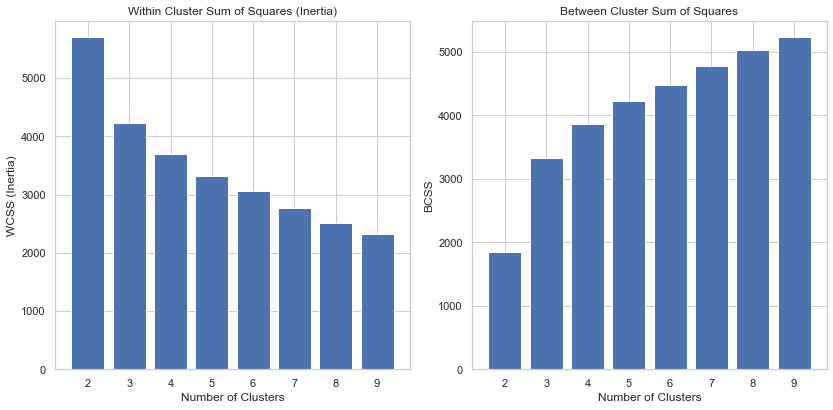

In [6]:
#evaluating the KMeans model with WCSS and BCSS
def wcss_bcss(df):
    fig, ax = plt.subplots(1, 2, figsize = (12, 6))
    fig.tight_layout(pad = 3)
    
    #plot the WCSS
    ax[0].bar(df['Cluster'], df['WCSS'])
    ax[0].set(
    title = "Within Cluster Sum of Squares (Inertia)",
    xlabel = "Number of Clusters",
    ylabel = "WCSS (Inertia)")    
    
    #plot the BCSS = TSS - WCSS
    ax[1].bar(df['Cluster'], df['BCSS'])
    ax[1].set(
    title = "Between Cluster Sum of Squares",
    xlabel = "Number of Clusters",
    ylabel = "BCSS")   

wcss_bcss(eval_kmeans)

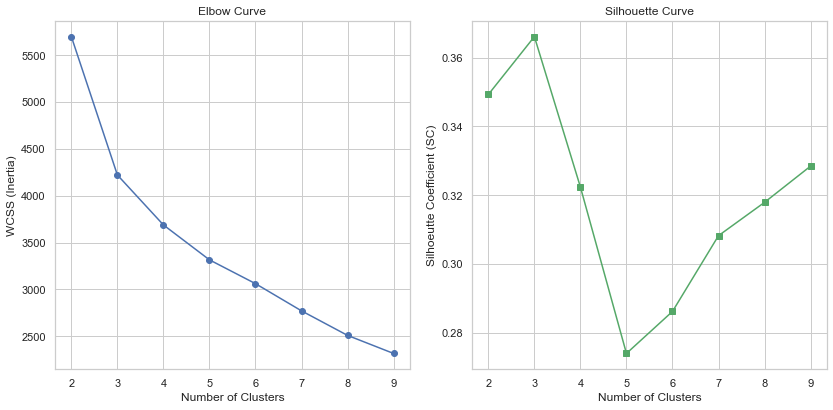

In [7]:
def eval_curves(df):
    fig, ax = plt.subplots(1, 2, figsize = (12, 6))
    fig.tight_layout(pad = 3)
    
    #plotting the elbow curve
    ax[0].plot(df['Cluster'], df['WCSS'], "bo-") #blue, "o" marker, line
    ax[0].set(
    title = "Elbow Curve",
    xlabel = "Number of Clusters",
    ylabel = "WCSS (Inertia)")
    
    #plotting the silhoutte curve
    ax[1].plot(df['Cluster'], df['SC'], "gs-") #blue, "s" marker, line
    ax[1].set(
    title = "Silhouette Curve",
    xlabel = "Number of Clusters",
    ylabel = "Silhoeutte Coefficient (SC)")

eval_curves(eval_kmeans)

From the above curves, we determine that our optimal number of clusters (k) = 3.

In [8]:
#fit the cluster
kmeans = KMeans(n_clusters = 3, init = "k-means++", random_state = 100)
kmeans.fit_predict(data_scaled)

#append the predicted clusters to the unscaled dataframe
data['Cluster'] = kmeans.labels_

#view the dataframe with cluster predictions
data

,EmpDuration_Company,EmpDuration_Position,Age_Decade,AttritionRisk,Position_>3Y,PromoEligibility,PerformanceRank_Current,PotentialRank_Current,Cluster
0,15.0,12.5,5,1,1,0,2,2,0
1,15.0,12.5,4,1,1,0,2,2,0
2,12.5,12.5,6,1,1,0,2,2,0
3,2.0,2.0,4,1,0,0,3,3,2
4,15.0,2.0,5,1,0,0,3,3,2
...,...,...,...,...,...,...,...,...,...
938,1.0,1.0,3,1,0,0,2,2,1
939,15.0,2.0,5,1,0,0,2,2,1
940,15.0,2.0,4,2,0,1,3,3,2
941,12.5,1.0,3,1,0,1,3,3,2


To better understand the clusters and their separation, we group the dataframe by clusters and generate a heatmap with their average values across the features:

In [9]:
#grouping by clusters
data_grouped = data.groupby('Cluster').apply(lambda x: x.describe())
data_grouped

EmpDuration_Company  EmpDuration_Position  Age_Decade  \
Cluster                                                                
0       count           160.000000            160.000000  160.000000   
        mean             11.350000              8.200000    4.256250   
        std               3.634132              3.631709    0.953292   
        min               4.000000              4.000000    3.000000   
        25%               7.500000              4.000000    4.000000   
        50%              12.500000              7.500000    4.000000   
        75%              15.000000             12.500000    5.000000   
        max              15.000000             15.000000    7.000000   
1       count           601.000000            601.000000  601.000000   
        mean              5.373544              1.530782    3.607321   
        std               4.553641              0.509380    0.891934   
        min               1.000000              1.000000    2.000000   
        25%               2.000000              1.000000    3.000000   
        50%               4.000000              2.000000    3.000000   
        75%               7.500000              2.000000    4.000000   
        max              15.000000              4.000000    6.000000   
2       count           182.000000            182.000000  182.000000   
        mean              5.956044              1.859890    3.412088   
        std               4.660963              0.826619    0.892242   
        min               1.000000              1.000000    2.000000   
        25%               2.000000              1.000000    3.000000   
        50%               4.000000              2.000000    3.000000   
        75%               7.500000              2.000000    4.000000   
        max              15.000000              7.500000    6.000000   

               AttritionRisk  Position_>3Y  PromoEligibility  \
Cluster                                                        
0       count     160.000000    160.000000        160.000000   
        mean        1.268750      1.000000          0.206250   
        std         0.510541      0.000000          0.405882   
        min         1.000000      1.000000          0.000000   
        25%         1.000000      1.000000          0.000000   
        50%         1.000000      1.000000          0.000000   
        75%         1.000000      1.000000          0.000000   
        max         3.000000      1.000000          1.000000   
1       count     601.000000    601.000000        601.000000   
        mean        1.354409      0.001664          0.193012   
        std         0.585250      0.040791          0.394991   
        min         1.000000      0.000000          0.000000   
        25%         1.000000      0.000000          0.000000   
        50%         1.000000      0.000000          0.000000   
        75%         2.000000      0.000000          0.000000   
        max         3.000000      1.000000          1.000000   
2       count     182.000000    182.000000        182.000000   
        mean        1.620879      0.065934          0.521978   
        std         0.700594      0.248851          0.500895   
        min         1.000000      0.000000          0.000000   
        25%         1.000000      0.000000          0.000000   
        50%         1.000000      0.000000          1.000000   
        75%         2.000000      0.000000          1.000000   
        max         3.000000      1.000000          1.000000   

               PerformanceRank_Current  PotentialRank_Current  Cluster  
Cluster                                                                 
0       count               160.000000             160.000000    160.0  
        mean                  2.125000               2.125000      0.0  
        std                   0.384446               0.384446      0.0  
        min                   1.000000               1.000000      0.0  
        25%                   2.000000 

In [10]:
#extracting only the mean values from .describe
data_grouped2 = data.groupby('Cluster').apply(lambda x: x.describe().loc[['mean']])
data_grouped2

,,EmpDuration_Company,EmpDuration_Position,Age_Decade,AttritionRisk,Position_>3Y,PromoEligibility,PerformanceRank_Current,PotentialRank_Current,Cluster
Cluster,,,,,,,,,,
0,mean,11.350000,8.200000,4.256250,1.268750,1.000000,0.206250,2.125000,2.125000,0.0
1,mean,5.373544,1.530782,3.607321,1.354409,0.001664,0.193012,1.950083,1.950083,1.0
2,mean,5.956044,1.859890,3.412088,1.620879,0.065934,0.521978,3.000000,3.000000,2.0


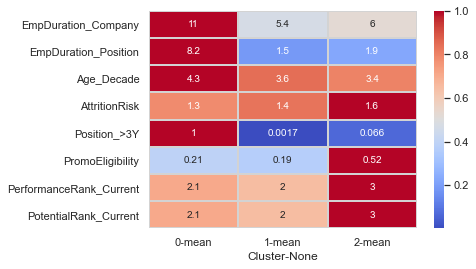

In [11]:
#to better visualize the heatmap, we normalize each row by its maximum value
#we also transpose (with .T) to flip the axis
data_grouped2_n = data_grouped2.T.div(data_grouped2.T.max(axis = 1), axis = 0)

#plotting the heatmap
ax = sns.heatmap(data_grouped2_n.drop('Cluster'), linecolor = "lightgrey", linewidth = 1, 
            cmap = "coolwarm", annot = data_grouped2.T.drop('Cluster'), fmt = '.2g') #we set annot to original

From the above, we make the following observations and define each cluster as follows:
- **Cluster 0: "Cruisers"**
    - Longest employment within the firm,
    - Longest time in current position,
    - Oldest,
    - Lowest risk of attrition
    - Medium Performance and Potential    
- **Cluster 1: "Adjusting-newbies"**
    - Shortest employment within the firm,
    - Shortest time in current position,
    - Middle-aged,
    - Medium risk of attrition,
    - Lowest probability of promotion,
    - Lowest Performance and Potential   
- **Cluster 2: "High-flyers"**
    - Medium employment within the firm,
    - Medium time in current position,
    - Youngest,
    - Highest risk of attrition,
    - Highest probability of promotion,
    - Highest Performance and Potential

In [12]:
#redefine the cluster names
data['Cluster'] = data['Cluster'].map({0: "Cruisers", 
                                       1: "Adjusting-newbies", 
                                       2: "High-flyers"})
#add back 'emp_id'
data['emp_id'] = df['emp_id']

#export table to .csv for HR
data.to_csv("dummy_HR_data_Clusters-KMeans.csv", index = False)